(GMM)=

# Gaussian Mixture Models

The Gaussian Mixture Models (GMM) can be viewed as an extension of K-means. Instead of 
using a hard clustering method to assign each data point to one and only one cluster, 
the Gaussian Mixture Models estimates the probability of a data point coming from each cluster.

## Mathematics

Suppose that we have $N$ observations with $D$ dimensions. 
The model is a mixture of $K$ different Gaussian distributions, each with its own
mean $\boldsymbol{\mu}_k$ and variance $\boldsymbol{\Sigma}_k$ such that within each cluster,
the probability of observing $\boldsymbol{x}_i$ is

\begin{equation*}
N( \boldsymbol{x}_i|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)=
\frac{1}{(2\pi)^{D/2}|\boldsymbol{\Sigma}_k|^{1/2}}
\left( 
-\frac{1}{2}(\boldsymbol{x}_i-\boldsymbol{\mu}_k)^T(\boldsymbol{\Sigma}_k)^{-1}
(\boldsymbol{x}_i-\boldsymbol{\mu}_k)
\right).
\end{equation*}

We define a latent variable $\boldsymbol{z}=(z_{1},z_{2},\dots z_{K})$, 
where $z_{k}$ is 1 if a data point of interest comes from Gaussian $k$, and 0 otherwise. 
Now the overall probability of observing a point that comes from Gaussian $k$ is

\begin{equation*}
P(z_{k}=1) = \pi_k.
\end{equation*}

Thus, each Gaussian in the model will have the following parameters: $\pi_k$, 
$\boldsymbol{\mu}_k$, $\boldsymbol{\Sigma}_k$.



## Expectation - Maximization Algorithm (EM)

1. Initialize $\theta=(\pi_k, 
\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ randomly
1. Alternate:
    - E-step: based on $\theta$, calculate the expectation of log-likelihood and estimate $\gamma(z_{ik})$, 
      the poterior probability that observation $\boldsymbol{x}_i$ comes from Gaussian $k$
    - M-step: update $\theta$ by maximizing the expectation of log-likelihood 
      based on $\gamma(z_{ik})$
1. When the algorithm converges or when `iter = max_iter`, terminate.

For more details about mathematics and the EM algorithm: 
<https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95>, 
<https://towardsdatascience.com/gaussian-mixture-models-vs-k-means-which-one-to-choose-62f2736025f0>.

## Implementation

GMM can also be implemented by importing the `scikit-learn` package.

## Iris data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
iris_data = datasets.load_iris()
iris = pd.DataFrame(iris_data.data,columns=["sepal_length","sepal_width","petal_length","petal_width"])
iris['species'] = pd.Series(iris_data.target)
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


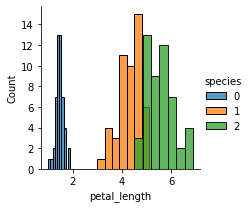

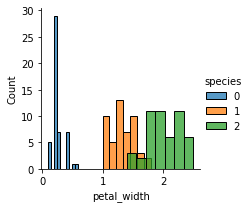

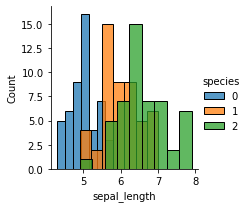

In [3]:
sns.FacetGrid(iris,hue="species", height=3).map(sns.histplot,"petal_length").add_legend()
sns.FacetGrid(iris,hue="species", height=3).map(sns.histplot,"petal_width").add_legend()
sns.FacetGrid(iris,hue="species", height=3).map(sns.histplot,"sepal_length").add_legend()
plt.show()

For a more concise visualization later, we just select `sepal_length` and `sepal_width` as the input variables.

In [4]:
X = iris.iloc[:, [0, 1]].values
y = iris.iloc[:, 4]

### Training GMM

In [5]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components = 3)
GMM.fit(X)

GaussianMixture(n_components=3)

### Results
We can plot the Gaussians by using a `plot_gmm` function defined on 
<https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html>.

In [6]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

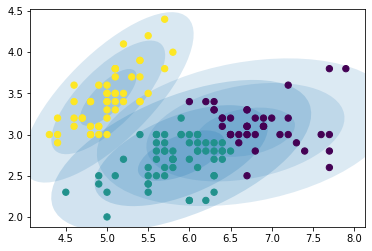

In [7]:
plot_gmm(GMM, X)

In [8]:
# print the converged log-likelihood value
print(GMM.lower_bound_)
 
# print the number of iterations needed
# for the log-likelihood value to converge
print(GMM.n_iter_)

-1.4987505566235166
8


### Prediction

If we have some new data, we can use `GMM.predict` to predict which Gaussian they belong to.

In [9]:
from numpy.random import choice
from numpy.random import multivariate_normal

# first choose the clusters for 4 new data points
draw = choice(range(3), 4, p=GMM.weights_)

# sample the new data points within their chosen cluster
sample_test=[]
for i in range(len(draw)): 
    n = draw[i]
    sample_test.append(
        multivariate_normal(GMM.means_[n],GMM.covariances_[n]))

In [10]:
GMM.predict(sample_test)

array([2, 1, 0, 1])

## Comparison to K-means

Both GMM and K-means are unsupervised clustering models, but GMM seems to be more robust 
as it introduces probabilities. However, GMM is generally slower than K-Means because 
it takes more iterations to converge. GMM can also quickly converge to a local minimum, 
not the optimal solution.

In practice, GMM can be initialized by K-Means centroids to speed up the convergence.